# Complete Lab Solution: Hyperspectral Unmixing with Constrained Optimization

This notebook provides the complete solution to all lab exercises, serving as a reference implementation and comprehensive demonstration of hyperspectral unmixing techniques.

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Mathematical Background](#theory)
3. [Unconstrained Least Squares](#unconstrained)
4. [Constrained Optimization Methods](#constrained)
5. [Advanced: Blind Unmixing](#blind)
6. [Performance Comparison](#comparison)
7. [Practical Considerations](#practical)
8. [Conclusions](#conclusions)

## 1. Setup and Data Loading {#setup}

Let's start by importing all necessary modules and loading the data.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.linalg import norm
import warnings
import time
import sys
import os

# Add src to path
sys.path.append('../src')

# Lab modules
from data_loader import HyperspectralDataLoader, create_synthetic_data
from visualization import HSIVisualizer
from optimization import HyperspectralUnmixer, BlindUnmixer, adaptive_step_size
from metrics import UnmixingEvaluator, compute_endmember_similarity
from synthetic_image_creator import SyntheticImageCreator

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(42)
warnings.filterwarnings('ignore', category=UserWarning)

%matplotlib inline

print("Remote Sensing Optimization Lab - Complete Solution")
print("=" * 60)

Remote Sensing Optimization Lab - Complete Solution


### Data Loading and Initial Exploration

Created synthetic HSI data with shape: (32, 32, 200)
Created ground truth with shape: (32, 32)
Number of spectral bands: 200
Number of shapes: 4
✓ Real data loaded successfully
Extracted 4 endmembers with 200 spectral bands
Extracted 4 endmembers: ['Shape_1', 'Shape_2', 'Shape_3', 'Shape_5']
Dataset: 32×32 pixels, 200 bands
Vectorized data: (200, 1024) (bands × pixels)


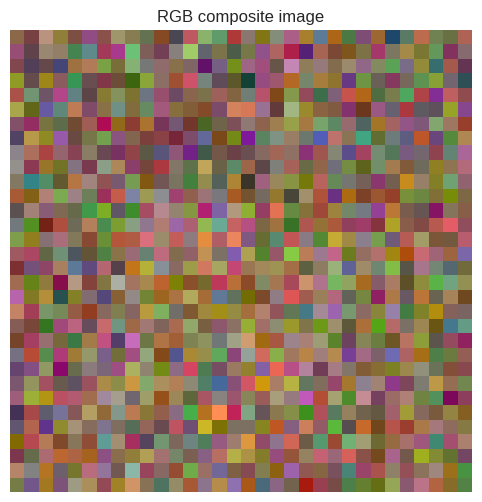

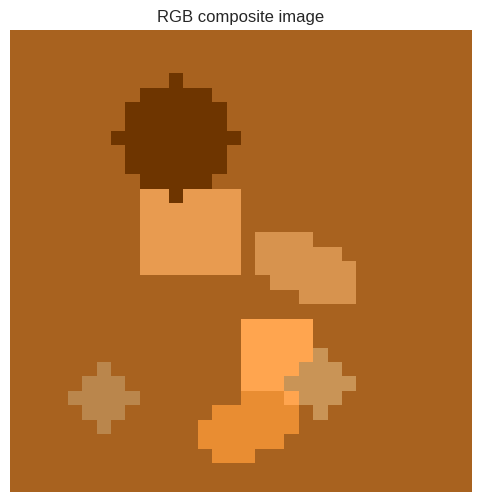

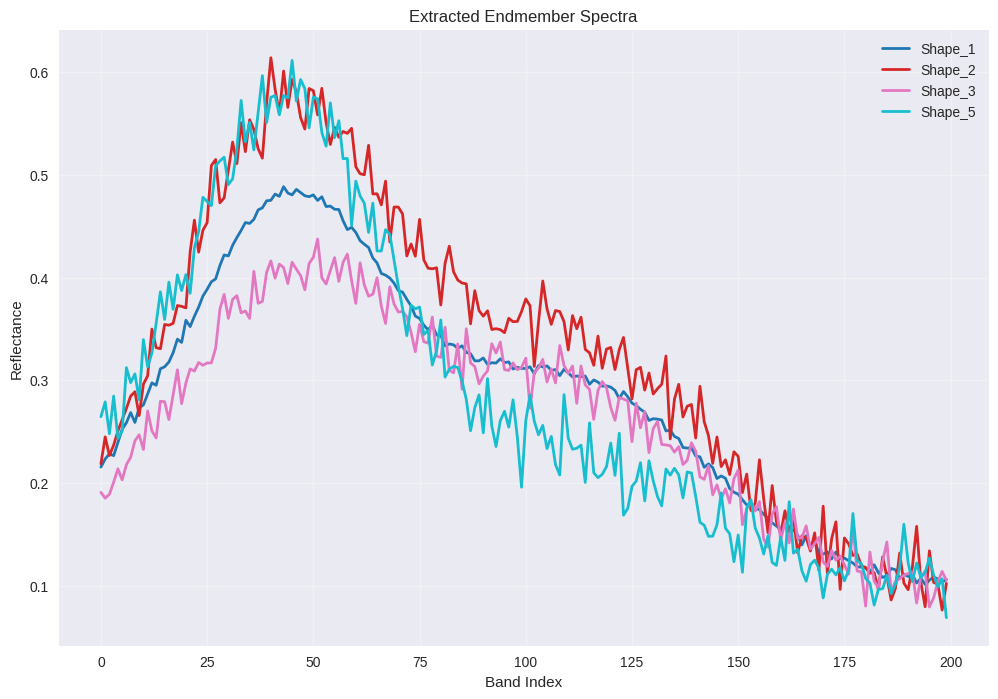

In [6]:
# Initialize components
data_path = "../data"
loader = HyperspectralDataLoader(data_path)
visualizer = HSIVisualizer(figsize=(12, 8))
unmixer = HyperspectralUnmixer()
evaluator = UnmixingEvaluator()

# Load Indian Pines dataset
try:
    hsi_true, hsi_data, ground_truth, abundance_map = loader.load_synthetic(bands=200, num_endmembers=5, height=32, width=32, noise_level=0.1)
    print("✓ Real data loaded successfully")
except FileNotFoundError:
    print("⚠ Indian Pines data not found, using synthetic data")
    hsi_data, S_library, A_library = create_synthetic_data(
        height=100, width=100, bands=200, num_endmembers=5, noise_level=0.5)
    ground_truth = np.random.randint(0, 6, (100, 100))



# Extract endmembers from ground truth
class_indices = [i for i in range(len(loader.class_names))]
S, endmember_names = loader.extract_class_spectra(class_indices)
print(f"Extracted {S.shape[1]} endmembers: {list(endmember_names)}")

# # Get basic information
info = loader.get_data_info()
print(f"Dataset: {info['height']}×{info['width']} pixels, {info['bands']} bands")

# # Vectorize data
height, width, bands = hsi_data.shape
Y = hsi_data.reshape(-1, bands).T
Y_true = hsi_true.reshape(-1, bands).T
print(f"Vectorized data: {Y.shape} (bands × pixels)")

# # Extract endmembers from ground truth
# class_indices = [i for i in range(len(loader.class_names))]
# S, endmember_names = loader.extract_class_spectra(class_indices)
# print(f"Extracted {S.shape[1]} endmembers: {list(endmember_names)}")

# Y, gt_vector = loader.vectorize_data()
# # Basic visualization
rgb_bands = loader.get_rgb_bands()
visualizer.plot_rgb_composite(hsi_data, rgb_bands, "RGB composite image")
visualizer.plot_rgb_composite(hsi_true, rgb_bands, "RGB composite image")
visualizer.plot_spectra(S, endmember_names, title="Extracted Endmember Spectra")

## 2. Mathematical Background {#theory}

### Linear Mixing Model

The linear mixing model for hyperspectral data is:

$$\mathbf{Y} = \mathbf{S}\mathbf{A} + \mathbf{N}$$

Where:
- $\mathbf{Y} \in \mathbb{R}^{m \times n}$: Observed data matrix (bands × pixels)
- $\mathbf{S} \in \mathbb{R}^{m \times K}$: Endmember matrix (bands × endmembers)
- $\mathbf{A} \in \mathbb{R}^{K \times n}$: Abundance matrix (endmembers × pixels)
- $\mathbf{N} \in \mathbb{R}^{m \times n}$: Noise matrix

### Physical Constraints

1. **Non-negativity**: $a_{ij} \geq 0$ (abundances cannot be negative)
2. **Sum-to-one**: $\sum_{i=1}^K a_{ip} = 1$ (abundances are proportions)
3. **Combined (Simplex)**: Both constraints define the unit simplex

## 3. Unconstrained Least Squares {#unconstrained}

Starting with the simplest case - unconstrained optimization.

UNCONSTRAINED LEAST SQUARES SOLUTION
Computation time: 0.0009 seconds
Reconstruction metrics:
  SAM (degrees): 2.5685
  RMSE: 0.016586
  SNR (dB): 25.50

Constraint violations:
  Negative abundances: 41.09%
  Sum deviation: 0.0567
  Min abundance: -1.4299
  Max abundance: 2.9459

Visualizing unconstrained results...


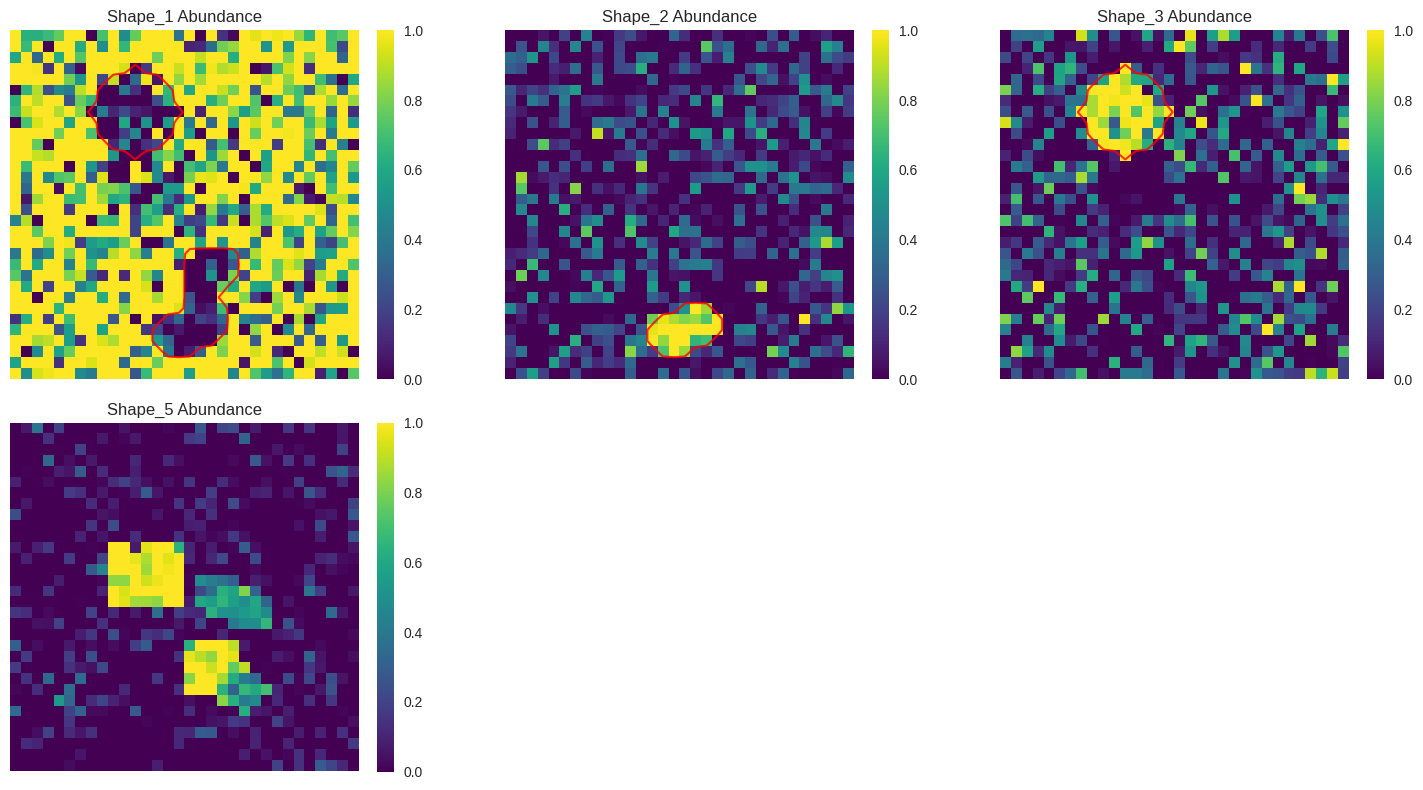

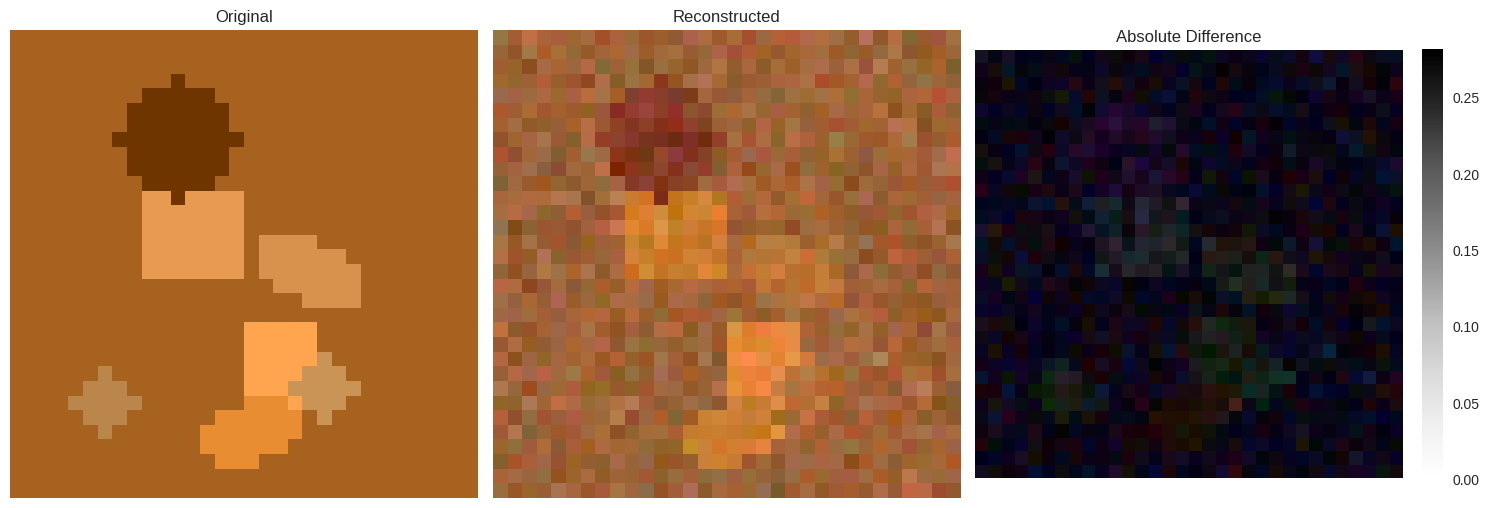

In [7]:
print("UNCONSTRAINED LEAST SQUARES SOLUTION")
print("=" * 40)

# Analytical solution: A* = (S^T S)^(-1) S^T Y
start_time = time.time()
A_unconstrained = unmixer.unconstrained_least_squares(S, Y)
unconstrained_time = time.time() - start_time

# Evaluate results
height, width = hsi_data.shape[:2]
results_unconstrained = evaluator.evaluate_reconstruction(
    S, A_unconstrained, Y_true, (height, width), rgb_bands)
abundance_stats_unconstrained = evaluator.evaluate_abundances(A_unconstrained)

print(f"Computation time: {unconstrained_time:.4f} seconds")
print(f"Reconstruction metrics:")
print(f"  SAM (degrees): {results_unconstrained['mean_sam_degrees']:.4f}")
print(f"  RMSE: {results_unconstrained['rmse']:.6f}")
print(f"  SNR (dB): {results_unconstrained['snr_db']:.2f}")

print(f"\nConstraint violations:")
print(f"  Negative abundances: {abundance_stats_unconstrained['fraction_negative']*100:.2f}%")
print(f"  Sum deviation: {abundance_stats_unconstrained['mean_sum_deviation']:.4f}")
print(f"  Min abundance: {abundance_stats_unconstrained['min_abundance']:.4f}")
print(f"  Max abundance: {abundance_stats_unconstrained['max_abundance']:.4f}")

# Visualize problematic abundances
print("\nVisualizing unconstrained results...")
visualizer.plot_abundance_maps(A_unconstrained, ground_truth ,(height, width), endmember_names, cmap='viridis')
# visualizer.plot_abundance_statistics(A_unconstrained, endmember_names)

# Plot reconstruction comparison
Y_reconstructed = S @ A_unconstrained
hsi_reconstructed = Y_reconstructed.T.reshape(height, width, -1)
visualizer.plot_reconstruction_comparison(hsi_true, hsi_reconstructed, rgb_bands)

### Analysis of Unconstrained Results

The unconstrained solution often produces:
- **Negative abundances**: Physically meaningless
- **Sum ≠ 1**: Violates conservation of energy
- **Good reconstruction error**: But poor physical interpretation

This motivates the need for constrained optimization.

## 4. Constrained Optimization Methods {#constrained}

Now we implement and compare different constraint strategies.

In [8]:
print("CONSTRAINED OPTIMIZATION METHODS")
print("=" * 35)

# Dictionary to store all results
all_methods = {}
all_abundances = {}
all_times = {}
all_objectives = {}

# Method 1: Sum-to-one constrained
print("\n1. Sum-to-one constrained least squares...")
start_time = time.time()
A_sum_to_one = unmixer.sum_to_one_constrained_ls(S, Y)
sum_to_one_time = time.time() - start_time

results_sum = evaluator.evaluate_reconstruction(S, A_sum_to_one, Y_true, (height, width), rgb_bands)
abundance_stats_sum = evaluator.evaluate_abundances(A_sum_to_one)

all_methods['Sum-to-one'] = results_sum
all_abundances['Sum-to-one'] = A_sum_to_one
all_times['Sum-to-one'] = sum_to_one_time

print(f"   Time: {sum_to_one_time:.4f}s, SAM: {results_sum['mean_sam_degrees']:.4f}°")
print(f"   Sum deviation: {abundance_stats_sum['mean_sum_deviation']:.2e}")

# Method 2: Non-negativity constrained
print("\n2. Non-negativity constrained (projected gradient)...")
start_time = time.time()
step_size = adaptive_step_size(S, initial_step=0.1)
A_non_neg, obj_nn = unmixer.projected_gradient_descent(
    S, Y, constraint_type='non_negative', max_iter=1000, step_size=step_size,tolerance=1e-12)
non_neg_time = time.time() - start_time

results_nn = evaluator.evaluate_reconstruction(S, A_non_neg, Y_true, (height, width), rgb_bands)
abundance_stats_nn = evaluator.evaluate_abundances(A_non_neg)

all_methods['Non-negative'] = results_nn
all_abundances['Non-negative'] = A_non_neg
all_times['Non-negative'] = non_neg_time
all_objectives['Non-negative'] = obj_nn

print(f"   Time: {non_neg_time:.4f}s, SAM: {results_nn['mean_sam_degrees']:.4f}°")
print(f"   Iterations: {len(obj_nn)}, Negative fraction: {abundance_stats_nn['fraction_negative']:.2e}")

# Method 3: Fully constrained (simplex)
print("\n3. Fully constrained (simplex projection)...")
start_time = time.time()
A_simplex, obj_simplex = unmixer.fully_constrained_least_squares(
    S, Y, max_iter=100, step_size=step_size, tolerance=1e-12)
simplex_time = time.time() - start_time

results_simplex = evaluator.evaluate_reconstruction(S, A_simplex, Y_true, (height, width), rgb_bands)
abundance_stats_simplex = evaluator.evaluate_abundances(A_simplex)

all_methods['Simplex'] = results_simplex
all_abundances['Simplex'] = A_simplex
all_times['Simplex'] = simplex_time
all_objectives['Simplex'] = obj_simplex

print(f"   Time: {simplex_time:.4f}s, SAM: {results_simplex['mean_sam_degrees']:.4f}°")
print(f"   Iterations: {len(obj_simplex)}, Simplex fraction: {abundance_stats_simplex['fraction_in_simplex']:.4f}")

# Add unconstrained for comparison
all_methods['Unconstrained'] = results_unconstrained
all_abundances['Unconstrained'] = A_unconstrained
all_times['Unconstrained'] = unconstrained_time

print("\n" + "=" * 50)
print("CONSTRAINED METHODS COMPLETED")

CONSTRAINED OPTIMIZATION METHODS

1. Sum-to-one constrained least squares...
   Time: 0.0016s, SAM: 2.2818°
   Sum deviation: 9.95e-17

2. Non-negativity constrained (projected gradient)...
   Time: 0.4084s, SAM: 1.8850°
   Iterations: 1000, Negative fraction: 0.00e+00

3. Fully constrained (simplex projection)...
   Time: 1.1883s, SAM: 1.8710°
   Iterations: 100, Simplex fraction: 1.0000

CONSTRAINED METHODS COMPLETED


### Convergence Analysis

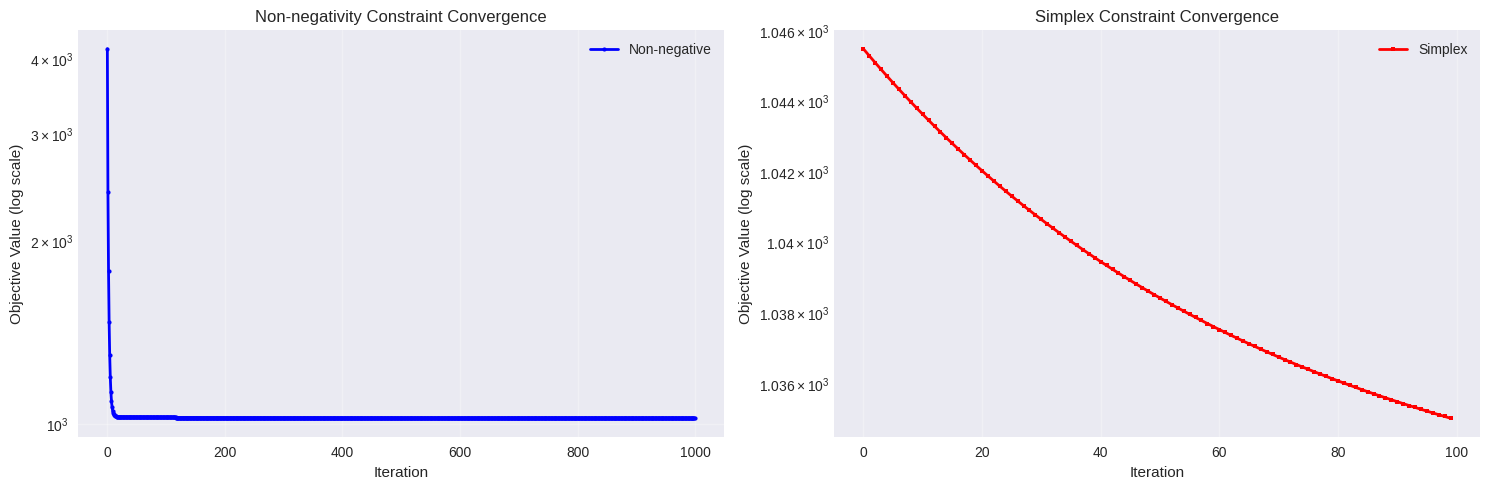

Non-negative convergence rate: 0.7541
Simplex convergence rate: 0.0100


In [9]:
# Plot convergence behavior
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Non-negativity convergence
if 'Non-negative' in all_objectives:
    axes[0].semilogy(all_objectives['Non-negative'], 'b-', linewidth=2, 
                     label='Non-negative', marker='o', markersize=3)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Objective Value (log scale)')
    axes[0].set_title('Non-negativity Constraint Convergence')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

# Simplex convergence
if 'Simplex' in all_objectives:
    axes[1].semilogy(all_objectives['Simplex'], 'r-', linewidth=2, 
                     label='Simplex', marker='s', markersize=3)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Objective Value (log scale)')
    axes[1].set_title('Simplex Constraint Convergence')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

plt.tight_layout()
plt.show()

# Convergence rates
for method, obj_vals in all_objectives.items():
    if len(obj_vals) > 1:
        convergence_rate = (obj_vals[0] - obj_vals[-1]) / obj_vals[0]
        print(f"{method} convergence rate: {convergence_rate:.4f}")

### Comprehensive Method Comparison

In [10]:
# Create comprehensive comparison table
print("COMPREHENSIVE METHOD COMPARISON")
print("=" * 40)

# Prepare data for comparison
comparison_data = []
for method_name in ['Unconstrained', 'Sum-to-one', 'Non-negative', 'Simplex']:
    if method_name in all_methods:
        results = all_methods[method_name]
        abundances = all_abundances[method_name]
        computation_time = all_times[method_name]
        abundance_stats = evaluator.evaluate_abundances(abundances)
        
        comparison_data.append({
            'Method': method_name,
            'SAM (°)': results['mean_sam_degrees'],
            'RMSE': results['rmse'],
            'SNR (dB)': results['snr_db'],
            'Time (s)': computation_time,
            'Negative %': abundance_stats['fraction_negative'] * 100,
            'Sum Dev.': abundance_stats['mean_sum_deviation'],
            'In Simplex %': abundance_stats['fraction_in_simplex'] * 100
        })

# Create DataFrame and display
df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.round({
    'SAM (°)': 4, 'RMSE': 6, 'SNR (dB)': 2, 'Time (s)': 4,
    'Negative %': 2, 'Sum Dev.': 2, 'In Simplex %': 2
})

print(df_comparison.to_string(index=False))

# Highlight best performance
print("\nBest Performance Metrics:")
print(f"• Lowest SAM: {df_comparison.loc[df_comparison['SAM (°)'].idxmin(), 'Method']} "
      f"({df_comparison['SAM (°)'].min():.4f}°)")
print(f"• Lowest RMSE: {df_comparison.loc[df_comparison['RMSE'].idxmin(), 'Method']} "
      f"({df_comparison['RMSE'].min():.6f})")
print(f"• Highest SNR: {df_comparison.loc[df_comparison['SNR (dB)'].idxmax(), 'Method']} "
      f"({df_comparison['SNR (dB)'].max():.2f} dB)")
print(f"• Best Constraint Satisfaction: {df_comparison.loc[df_comparison['In Simplex %'].idxmax(), 'Method']} "
      f"({df_comparison['In Simplex %'].max():.2f}%)")

# Use the built-in comparison method
print("\n" + "=" * 50)
evaluator.compare_methods(all_methods)

COMPREHENSIVE METHOD COMPARISON
       Method  SAM (°)     RMSE  SNR (dB)  Time (s)  Negative %  Sum Dev.  In Simplex %
Unconstrained   2.5685 0.016586     25.50    0.0009       41.09      0.06          1.07
   Sum-to-one   2.2818 0.015288     26.21    0.0016       41.21      0.00         12.79
 Non-negative   1.8850 0.013771     27.11    0.4084        0.00      0.03         20.61
      Simplex   1.8710 0.014823     26.48    1.1883        0.00      0.00        100.00

Best Performance Metrics:
• Lowest SAM: Simplex (1.8710°)
• Lowest RMSE: Non-negative (0.013771)
• Highest SNR: Non-negative (27.11 dB)
• Best Constraint Satisfaction: Simplex (100.00%)

Comparison of Unmixing Methods:
               mean_sam_radians  mean_sam_degrees  std_sam_degrees    rmse  \
Sum-to-one               0.0398            2.2818           1.1546  0.0153   
Non-negative             0.0329            1.8850           1.1653  0.0138   
Simplex                  0.0327            1.8710           1.3632  0.0148

### Visualize Best Results

Visualizing results for best method: Simplex


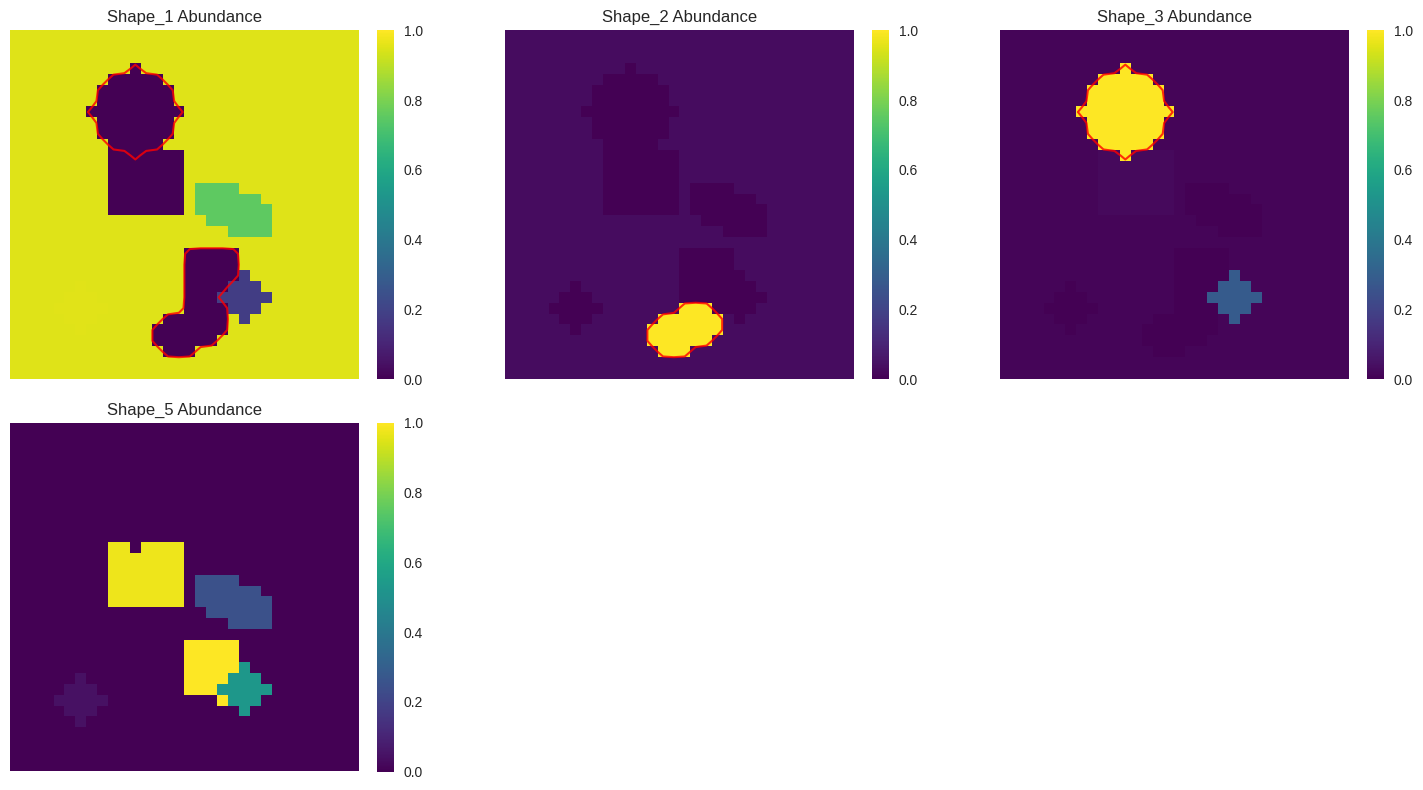

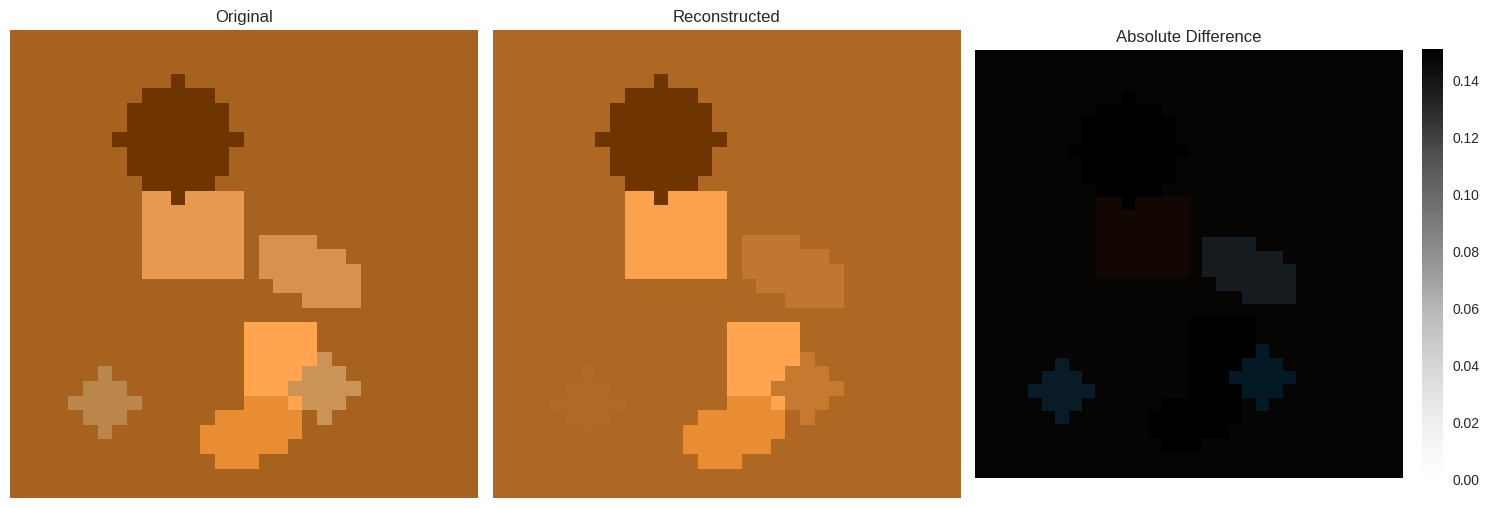

In [42]:
# Find the best method based on overall performance
best_method = 'Simplex'  # Usually the best compromise
A_best = all_abundances[best_method]

print(f"Visualizing results for best method: {best_method}")

# Plot abundance maps
visualizer.plot_abundance_maps(A_best, ground_truth, (height, width), endmember_names, cmap='viridis')

# Plot reconstruction comparison
Y_reconstructed = S @ A_best
hsi_reconstructed = Y_reconstructed.T.reshape(height, width, -1)
visualizer.plot_reconstruction_comparison(hsi_true, hsi_reconstructed, rgb_bands)

# Abundance statistics
# visualizer.plot_abundance_statistics(A_best, endmember_names)

## 5. Advanced: Blind Unmixing {#blind}

Now let's tackle the challenging problem of blind unmixing where both endmembers and abundances are unknown.

In [16]:
from data_loader import create_synthetic_data

hsi, S, A = create_synthetic_data()

In [ ]:
visualizer.plot_abundance_maps(A, None, hsi.shape[::2], None)